<a href="https://colab.research.google.com/github/sureshkuc/Freie-Universitat-Berlin/blob/main/GEOMETRIC-DATA-ANALYSIS/Enzymes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install torch-geometric

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GraphConv, TopKPooling,GCNConv
from torch_geometric.nn import global_max_pool as gmp
from torch_geometric.nn import global_mean_pool as gap

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
n = len(dataset) // 10
test_dataset = dataset[:n]
train_dataset = dataset[n:]
test_loader = DataLoader(test_dataset, batch_size=32)
train_loader = DataLoader(train_dataset, batch_size=32)


class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = GCNConv(dataset.num_features, 128)
        self.pool1 = TopKPooling(128, ratio=0.8)
        self.conv2 = GCNConv(128, 128)
        self.pool2 = TopKPooling(128, ratio=0.8)
        self.conv3 = GCNConv(128, 128)
        self.pool3 = TopKPooling(128, ratio=0.8)
        self.lin_skip1 = torch.nn.Linear(dataset.num_features, 128)
        self.lin_skip2 = torch.nn.Linear(128,128)
        self.lin_skip3 = torch.nn.Linear(128, 128)
        self.lin1 = torch.nn.Linear(256, 128)
        self.lin2 = torch.nn.Linear(128, 64)
        self.lin3 = torch.nn.Linear(64, dataset.num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index)+self.lin_skip1(x))
        x, edge_index, _, batch, _, _ = self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv2(x, edge_index)+self.lin_skip2(x))
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = F.relu(self.conv3(x, edge_index)+self.lin_skip3(x))
        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim=1)

        x = x1 + x2 + x3

        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        x = F.log_softmax(self.lin3(x), dim=-1)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


def train(epoch):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

train_acc_list=[]
test_acc_list=[]
for epoch in range(1, 100):
    loss = train(epoch)
    train_acc = test(train_loader)
    train_acc_list.append(train_acc )
    test_acc = test(test_loader)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.5f}, Train Acc: {train_acc:.5f}, '
          f'Test Acc: {test_acc:.5f}')
def plot_acc(epochs,train_losses,test_losses):
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.plot(range(epochs),train_losses, label='train acc')
  plt.plot(range(epochs),test_losses,label='test acc')
  plt.title('Sparse Hierarchical Graph Classifier')
  plt.legend()
  plt.show()


Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


Epoch: 001, Loss: 1.79238, Train Acc: 0.17407, Test Acc: 0.15000
Epoch: 002, Loss: 1.79019, Train Acc: 0.18333, Test Acc: 0.13333
Epoch: 003, Loss: 1.78819, Train Acc: 0.18333, Test Acc: 0.13333
Epoch: 004, Loss: 1.78367, Train Acc: 0.18148, Test Acc: 0.11667
Epoch: 005, Loss: 1.77977, Train Acc: 0.21111, Test Acc: 0.15000
Epoch: 006, Loss: 1.77774, Train Acc: 0.20370, Test Acc: 0.18333
Epoch: 007, Loss: 1.76098, Train Acc: 0.24259, Test Acc: 0.30000
Epoch: 008, Loss: 1.75719, Train Acc: 0.25000, Test Acc: 0.25000
Epoch: 009, Loss: 1.76116, Train Acc: 0.24630, Test Acc: 0.28333
Epoch: 010, Loss: 1.74875, Train Acc: 0.24444, Test Acc: 0.28333
Epoch: 011, Loss: 1.75082, Train Acc: 0.22407, Test Acc: 0.28333
Epoch: 012, Loss: 1.75270, Train Acc: 0.22222, Test Acc: 0.26667
Epoch: 013, Loss: 1.73758, Train Acc: 0.25185, Test Acc: 0.35000
Epoch: 014, Loss: 1.74069, Train Acc: 0.24630, Test Acc: 0.33333
Epoch: 015, Loss: 1.73541, Train Acc: 0.29074, Test Acc: 0.33333
Epoch: 016, Loss: 1.72788

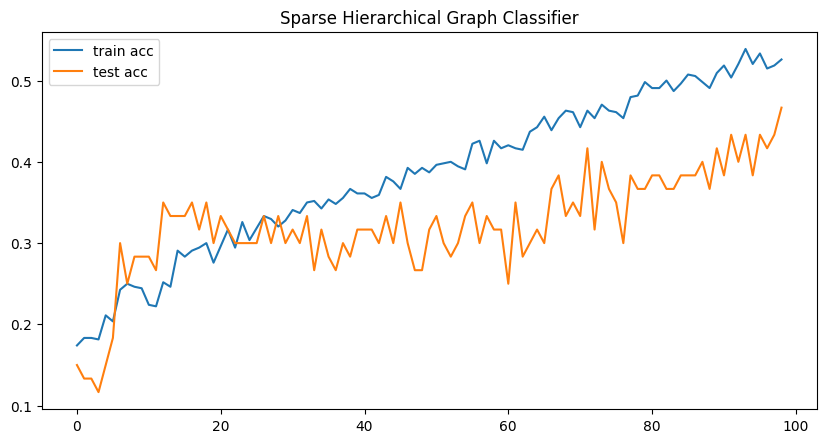

In [ ]:
plot_acc(99,train_acc_list,test_acc_list)

In [ ]:
from sklearn.model_selection import KFold
def train(epoch,train_loader):
    model.train()

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += data.num_graphs * loss.item()
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        pred = model(data).max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = dataset.shuffle()
batch_size=32
k=10
splits=KFold(n_splits=k,shuffle=True,random_state=42)
foldperf={}
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print(train_idx)
    print('Fold {}'.format(fold + 1))
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    test_dataset = dataset[val_idx]
    print(test_dataset)
    train_dataset = dataset[train_idx]
    test_loader = DataLoader(test_dataset, batch_size=60)
    train_loader = DataLoader(train_dataset, batch_size=60)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    for epoch in range(1, 100):
      loss = train(epoch,train_loader)
      train_acc = test(train_loader)
      #train_acc_list.append(train_acc )
      test_acc = test(test_loader)
      #test_acc_list.append(test_acc)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.5f}, Train Acc: {train_acc:.5f}, '
            f'Test Acc: {test_acc:.5f}')
      history['train_loss'].append(loss)
      #history['test_loss'].append(test_loss)
      history['train_acc'].append(train_acc)
      history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history 

[  0   1   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18  19
  20  21  22  23  25  26  27  28  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  56  57  58  59
  60  61  62  64  65  66  67  68  69  70  71  73  74  75  76  79  80  81
  83  84  85  87  88  89  90  91  92  93  94  95  96  97  98  99 100 102
 103 105 106 107 108 111 112 113 114 115 116 117 119 120 121 122 123 124
 125 126 127 128 129 130 131 133 134 136 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 164
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 183 185 186
 187 188 189 190 191 193 194 196 197 198 199 200 201 202 203 204 205 206
 207 208 210 211 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 235 236 237 238 239 240 241 242 243 244 246
 247 249 250 251 252 253 254 255 256 258 259 260 261 262 263 264 265 266
 267 268 269 270 271 272 273 274 276 277 278 279 28

In [ ]:
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=10
for f in range(1,k+1):

     tl_f.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
     #testl_f.append(np.mean(foldperf['fold{}'.format(f)]['test_loss']))

     ta_f.append(np.mean(foldperf['fold{}'.format(f)]['train_acc']))
     testa_f.append(np.mean(foldperf['fold{}'.format(f)]['test_acc']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Training Acc: {:.2f} \t Average Test Acc: {:.4f}".format(np.mean(tl_f),np.mean(ta_f),np.mean(testa_f)))

Performance of 10 fold cross validation
Average Training Loss: 1.443 	 Average Training Acc: 0.46 	 Average Test Acc: 0.35
